In [1]:
from transformers import pipeline, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer, set_seed, GemmaForCausalLM
import torch
from datasets import Dataset
import os
from sklearn.metrics import classification_report
os.environ['TRANSFORMERS_CACHE'] = "/local/home/furquanh/myProjects/final_fairness_project/Model_Training/cache/"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

def model_init(peft_dir):
    #model_name = "meta-llama/Llama-2-7b-chat-hf"
    #model_name = "mistralai/Mistral-7B-Instruct-v0.1"
    model_name="google/gemma-7b-it"
    model = GemmaForCausalLM.from_pretrained(
        model_name,  
        cache_dir="/local/home/furquanh/myProjects/final_fairness_project/Model_Training/cache/",
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    #model = PeftModel.from_pretrained(model, peft_dir)
    #tokenizer.pad_token_id = tokenizer.eos_token_id
    #tokenizer.pad_token = tokenizer.eos_token
    #model.config.pad_token_id = model.config.eos_token_id
    return model, tokenizer


In [2]:
model, tokenizer = model_init('')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
pipeline = pipeline(model=model, tokenizer=tokenizer, task="text-generation")

In [4]:
import pandas as pd

dataset = pd.read_csv("harmful_removed_datasets_final/Emojify _cleaned.csv")


        do_sample=True,
        top_k=2,
        max_new_tokens=4,
        return_full_text=False,
        temperature=0.6,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,

In [5]:
def get_sentiment_gemma(text):
    input = f"""
    <bos><start_of_turn>user
Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.<end_of_turn>
<start_of_turn>model
Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.<end_of_turn>
<start_of_turn>user
sentence: {text}
<start_of_turn>model"""
    #print(input)
    
    sequences = pipeline(
        input,
        do_sample=True,
        max_new_tokens=3,
        return_full_text=False,
        temperature=0.6,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,

        
        )
    res = sequences[0]['generated_text'].strip().lower()
    #print(res)
    if(len(res)> 0 and res[-1] == '.'):
        return res[:-1]
    else:
        return res
    #return res
    #for seq in sequences:
    #    print(f"Result: {seq['generated_text']}")

In [6]:
pred = []
for i in range(2000, 2100):
    sentiment = get_sentiment_llama(dataset['sentence'][i])
    pred.append(sentiment)
    print(f"{i} original sentiment: {dataset['sentiment'][i]} predicted sentiment: {sentiment}")
print(classification_report(dataset['sentiment'][2000:2100], pred))  

2000 original sentiment: positive predicted sentiment: positive
2001 original sentiment: negative predicted sentiment: negative
2002 original sentiment: negative predicted sentiment: negative
2003 original sentiment: negative predicted sentiment: negative
2004 original sentiment: positive predicted sentiment: negative
2005 original sentiment: negative predicted sentiment: negative
2006 original sentiment: negative predicted sentiment: negative
2007 original sentiment: negative predicted sentiment: negative
2008 original sentiment: negative predicted sentiment: negative
2009 original sentiment: negative predicted sentiment: negative


/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


2010 original sentiment: negative predicted sentiment: negative


KeyboardInterrupt: 

```python
    batch['text'] = [
            f"""<s>[INST] <<SYS>>
                You are an helpful assistant who can detect the sentiment for a given text. For a given sentence, classify it into one of two categories: 'positive' or 'negative'.
                <</SYS>>
                
                Sentence: {text}[/INST]
                Assistant: The sentiment of the given sentence is
             """ for text in batch['text']]
```

<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>
{{ user_message }} [/INST]

Gemma 7b: <bos><start_of_turn>user
Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.<end_of_turn>
<start_of_turn>model
Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.<end_of_turn>
<start_of_turn>user
sentence: {text}
<start_of_turn>model


Mistral 7b: f"""<s>[INST] Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only. [/INST] Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.</s>[INST] sentence: {text} [/INST]"""
 

In [6]:
def add_prompt_zero_shot(batch):
    batch['text'] = [ f"""
    <bos><start_of_turn>user
Your task is to do sentiment analysis. Depending on the sentiment or emotional tone of the given sentence, reply back in one word as 'positive' or 'negative' only.<end_of_turn>
<start_of_turn>model
Understood, you will provide me with a sentence and depending on the sentiment of the given sentence I have to reply back with 'positive' or 'negative'.<end_of_turn>
<start_of_turn>user
sentence: {text}
<start_of_turn>model"""   for text in batch['sentence']]
    return batch

In [7]:
def add_prompt_zero_shot_non_chat(batch):
    batch['text'] = [
            f"""<s>[INST] <<SYS>>
                Analyze the sentiment of the given sentence and reply back in one word, positive or negative.
                <</SYS>>
                
                Sentence: {text} [/INST]""" for text in batch['text']]
    return batch

In [20]:
def get_sentiment_llama_dataset(batch):
    # Assuming 'pipeline' is a batch-capable function for sentiment analysis
    sequences = pipeline(
        batch['text'],  # Pass the whole batch of texts
        do_sample=True,
        max_new_tokens=2,
        return_full_text=False,
        temperature=0.1,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id
    )

    predictions = []
    for sequence in sequences:
        res = sequence[0]['generated_text'].strip().lower()
        if(len(res)> 0 and res[-1] == '.'):
            predictions.append(res[:-1])
        else:
            predictions.append(res)
    batch['prediction'] = predictions
    return batch

# Reading all datasets

In [10]:
import os
import pandas as pd
from datasets import load_dataset

directory_path = "./harmful_removed_datasets/"

dataset_list = []

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        dataset = load_dataset('csv', data_files=file_path, split='all')
        dataset_list.append((dataset, filename.split('.')[0]))

In [11]:
#org_dataset = load_dataset('csv', data_files='final.csv', split='all')

In [12]:
#dataset_list.insert(0, (org_dataset, 'orginal_dataset'))

In [13]:
dataset_list[7][1]

'Subject-Verb Agreement Errors_cleaned'

In [14]:
print(dataset_list[0][1].split("_cleaned")[0])
dataset_list[0][0].to_pandas()

orginal_dataset


,sentence,sentiment
0,i hope you do because otherwise your wife will...,negative
1,i constantly worry about their fight against n...,positive
2,i didnt want to shoot him sorry to be a party ...,negative
3,i feel i ve had more unhappy years than happy ...,negative
4,im feeling im caring im healing im sharing amp...,positive
...,...,...
2453,Heather found herself in a dreadful situation.,negative
2454,i must tell you that i have been doing much mo...,positive
2455,i must admit by the time i got back dripping i...,negative
2456,This man told us all about the recent funny ev...,positive


## Getting predictions

In [15]:
from tqdm import tqdm
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(test))): #len(test)
        prompt = test.iloc[i]["text"]
        answer = get_sentiment_llama(prompt)
        y_pred.append(answer)
        #print(f"y_true = {test.iloc[i]['sentiment']} <-> y_pred = {answer}")
    return y_pred

# Original dataset

In [16]:
def predict_on_dataset(dataset, name):
    print(f"Getting models prediction on {name}...")
    #dataset = Dataset.from_pandas(dataset)
    dataset =  get_sentiment_llama_dataset(dataset)
    metrics = classification_report(y_true=dataset['sentiment'],y_pred=dataset['prediction'],  output_dict=True)
    return metrics

## Classification Report

In [17]:
def moderate_texts_to_dataframe(texts, pause=0.5):
    moderation_results = []
    for text in texts:
        result = moderate_text(text)
        moderation_results.append({"Text": text, "Flagged as harmful?": result})
        time.sleep(pause)  # To avoid hitting rate limits

    return pd.DataFrame(moderation_results)

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

Map:   0%|          | 0/2458 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

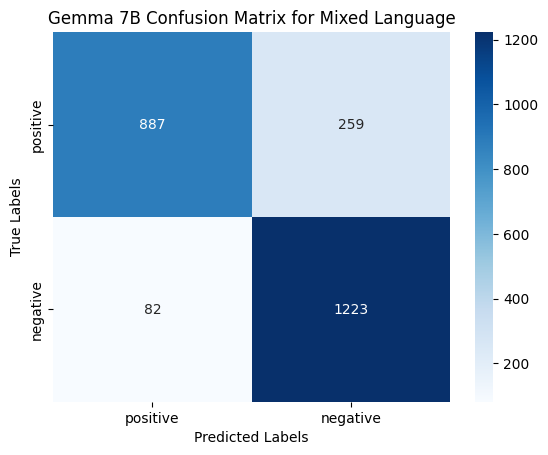

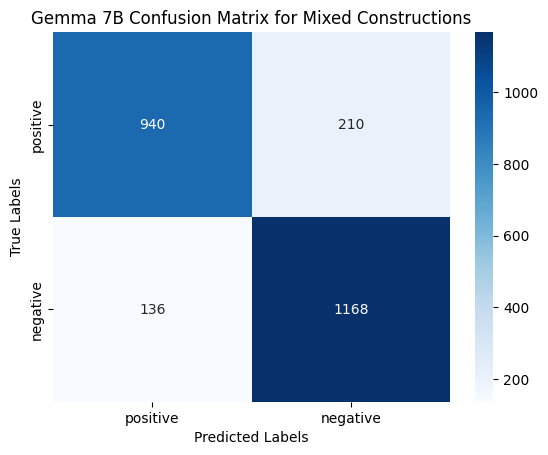

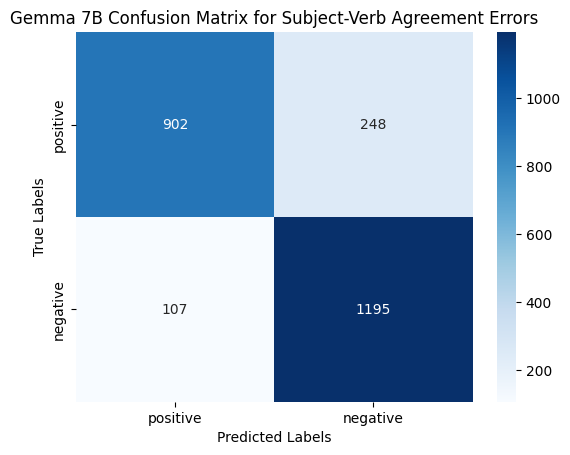

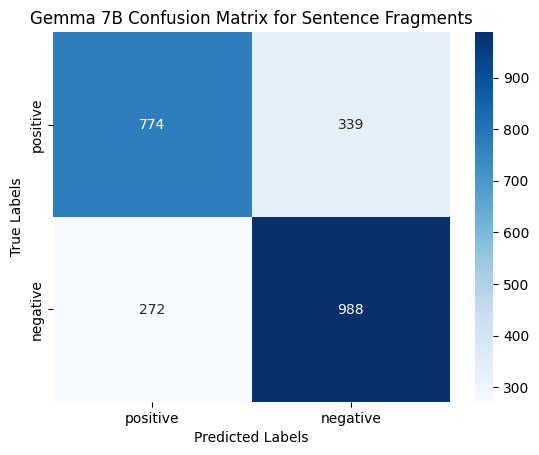

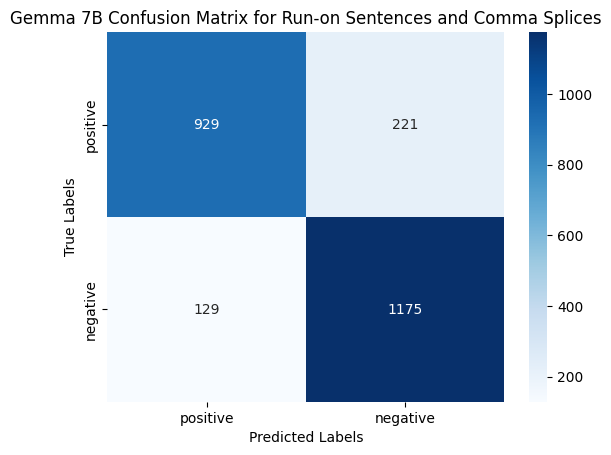

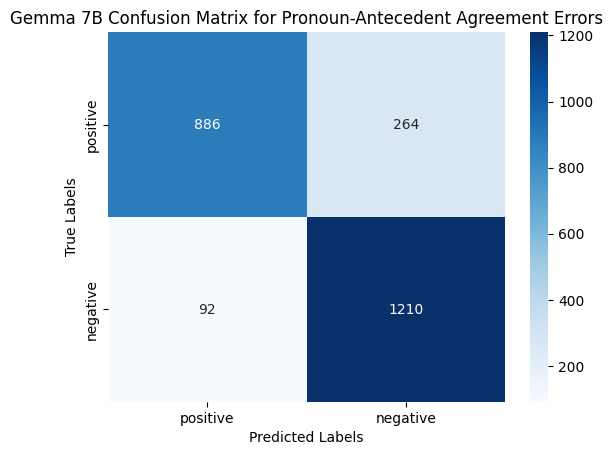

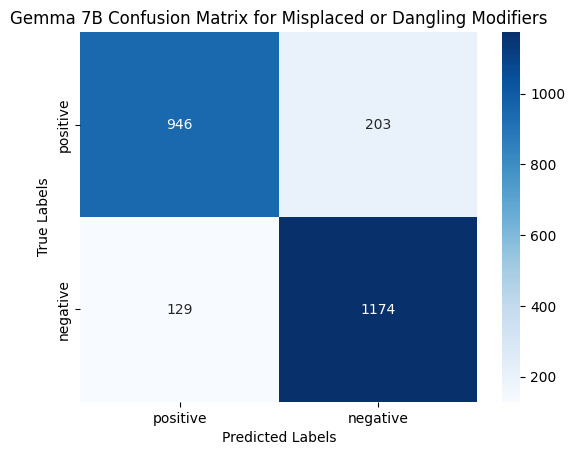

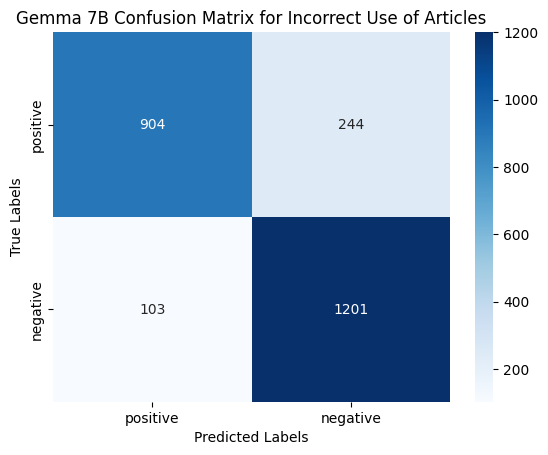

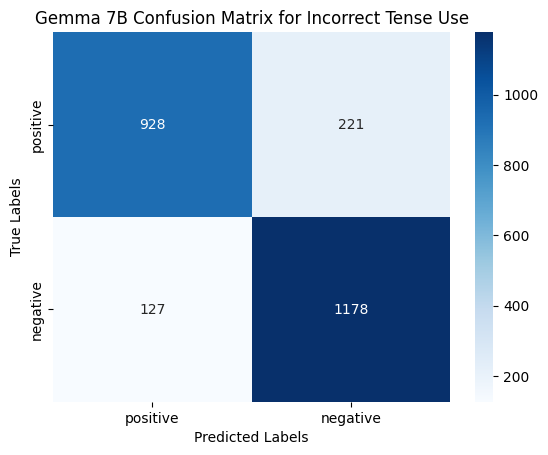

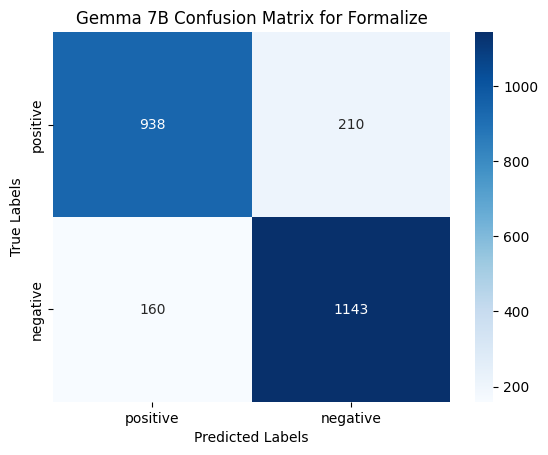

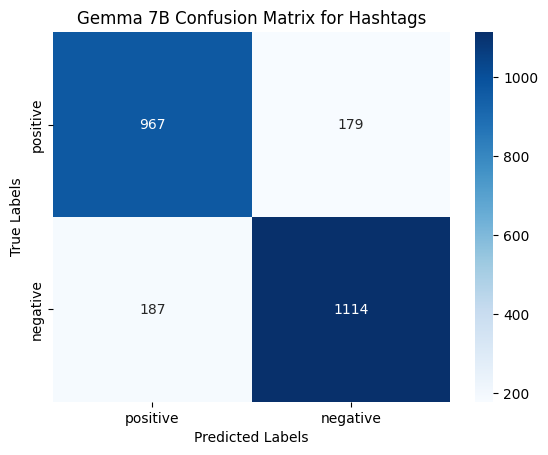

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
for dataset, name in dataset_list[5:]:
    dataset = dataset.map(add_prompt_zero_shot, batched=True)
    dataset = dataset.map(get_sentiment_llama_dataset, batched=True, batch_size=100)
    
    # Metrics. F1-score, accuracy, TPR and FPR
    metrics = classification_report(y_true=dataset['sentiment'],y_pred=dataset['prediction'], output_dict=True)
    cm = confusion_matrix(dataset['sentiment'], dataset['prediction'], labels=["positive", "negative"])
    dataframe = dataset.to_pandas() 
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    TNR = TN / (TN + FP)
    metrics['TPR'] = TPR
    metrics['FPR'] = FPR
    metrics['TNR'] = TNR
    metrics['FNR'] = FNR
    
    # Plotting the confusion matrix
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["positive", "negative"], yticklabels=["positive", "negative"])
    ax.set_title(f'Gemma 7B Confusion Matrix for {name.split("_cleaned")[0]}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    
    report_json = json.dumps(metrics, indent=4)
    with open(f'./0-shot-with-datasets-gemma-0.1/{name}_classification_report.json', 'w') as file:
        file.write(report_json)
    dataframe.to_csv(f"0-shot-with-datasets-gemma-0.1/{name}.csv")
    plt.savefig(f"./0-shot-with-datasets-gemma-0.1/plots/{name}_CM_plot.png")

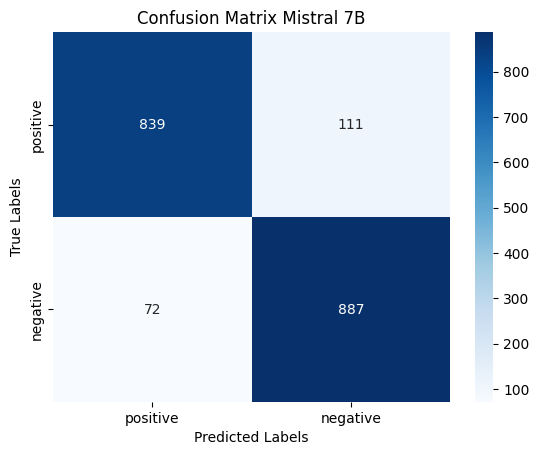

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["positive", "negative"], yticklabels=["positive", "negative"])
ax.set_title('Confusion Matrix Mistral 7B')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

report_json = json.dumps(metrics, indent=4)
with open(f'./0-shot-with-datasets-Mistral-0.6//{name}_classification_report.json', 'w') as file:
    file.write(report_json)
dataframe.to_csv(f"0-shot-with-datasets-Mistral-0.6//{name}.csv")
plt.savefig(f"./0-shot-with-datasets-Mistral-0.6//plots/{name}_CM_plot.png")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import json
for dataset, name in dataset_list:
    dataset = dataset.map(add_prompt_zero_shot, batched=True)
    dataset = dataset.map(get_sentiment_llama_dataset, batched=True, batch_size=100)
    
    # Metrics. F1-score, accuracy, TPR and FPR
    metrics = classification_report(y_true=dataset['sentiment'],y_pred=dataset['prediction'], output_dict=True)
    cm = confusion_matrix(dataset['sentiment'], dataset['prediction'], labels=["positive", "negative"])
    dataframe = dataset.to_pandas() 
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    metrics['TPR'] = TPR
    metrics['FPR'] = FPR
    
    report_json = json.dumps(metrics, indent=4)
    with open(f'./0-shot-with-datasets-gemma/{name}_classification_report.json', 'w') as file:
        file.write(report_json)
    dataframe.to_csv(f"0-shot-with-datasets-gemma/{name}.csv")

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import json
for dataset, name in dataset_list:
    dataset = dataset.map(add_prompt_two_shot, batched=True)
    dataset = dataset.map(get_sentiment_llama_dataset, batched=True, batch_size=100)
    
    # Metrics. F1-score, accuracy, TPR and FPR
    metrics = classification_report(y_true=dataset['sentiment'],y_pred=dataset['prediction'], output_dict=True)
    cm = confusion_matrix(dataset['sentiment'], dataset['prediction'], labels=["positive", "negative"])
    dataframe = dataset.to_pandas()
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    metrics['TPR'] = TPR
    metrics['FPR'] = FPR
    
    report_json = json.dumps(metrics, indent=4)
    with open(f'./2-shot-with-datasets/{name}_classification_report.json', 'w') as file:
        file.write(report_json)
    dataframe.to_csv(f"0-shot-with-datasets/{name}.csv")

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/augmentation-project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/home/furquanh/miniconda3/envs/a